# Laboratório: Fine-Tuning de LLMs para Instruction Following
Configuração do ambiente e verificação de versões.

In [ ]:
!pip install datasets pandas psutil requests tqdm tiktoken torch matplotlib llms-from-scratch

from importlib.metadata import version
import torch
import random
import time
import json
import os
import requests
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import tiktoken
from torch.utils.data import Dataset, DataLoader
from functools import partial

# Importações do repositório
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import (
    download_and_load_gpt2,
    load_weights_into_gpt,
    generate,
    text_to_token_ids,
    token_ids_to_text,
    plot_losses,
    calc_loss_loader,
    train_model_simple
)

torch.manual_seed(123)
random.seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Device: cuda


## 1. Construção do Dataset de Instruções
Carregando o AG News, formatando para instruções

In [ ]:
dataset = load_dataset("ag_news")
df = pd.DataFrame(dataset['train']).sample(2000, random_state=42)
label_map = {0: "Mundo", 1: "Esportes", 2: "Negócios", 3: "Ciência/Tecnologia"}

meu_dataset = []
for _, row in df.iterrows():
    if len(row['text']) > 50:
        meu_dataset.append({
            "instruction": "Classifique o texto da notícia abaixo em uma das seguintes categorias: Mundo, Esportes, Negócios ou Ciência/Tecnologia.",
            "input": row['text'],
            "output": label_map[row['label']]
        })

random.shuffle(meu_dataset)
total = len(meu_dataset)
train_data_medio = meu_dataset[:int(total * 0.8)]
val_data = meu_dataset[int(total * 0.8):int(total * 0.9)]
test_data = meu_dataset[int(total * 0.9):]

print(f"Treino Médio: {len(train_data_medio)} | Val: {len(val_data)} | Teste: {len(test_data)}")

def format_input(entry):
    instruction_text = (
        f"Abaixo está uma instrução que descreve uma tarefa. "
        f"Escreva uma resposta que conclua a solicitação adequadamente."
        f"\n\n### Instrução:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Entrada:\n{entry['input']}" if entry.get("input") else ""
    return instruction_text + input_text

print("\nExemplo formatado:")
print(format_input(train_data_medio[0]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Treino Médio: 1600 | Treino Peq: 400 | Val: 200 | Teste: 200

Exemplo formatado:
Abaixo está uma instrução que descreve uma tarefa. Escreva uma resposta que conclua a solicitação adequadamente.

### Instrução:
Classifique o texto da notícia abaixo em uma das seguintes categorias: Mundo, Esportes, Negócios ou Ciência/Tecnologia.

### Entrada:
Spam enforcers urged to work together Johannesburg, 12 October 2004 - International consumer law enforcers from 29 countries were yesterday urged to work together to combat the growing threat of spam.


## 2. Preparação dos DataLoaders (Analítico)
Usando a custom_collate_fn do Cap 07 e verificando o formato dos tensores gerados para garantir que o padding e a máscara (-100) funcionem.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Resposta:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
    def __getitem__(self, index): return self.encoded_texts[index]
    def __len__(self): return len(self.data)

def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    return torch.stack(inputs_lst).to(device), torch.stack(targets_lst).to(device)

## 2.1 Creating data loaders for an instruction dataset
Instanciando os lotes e inspecionando visualmente as matrizes para garantir que o padding e a máscara (-100) foram aplicados com sucesso.

In [ ]:
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=256)
batch_size = 8

train_dataset_medio = InstructionDataset(train_data_medio, tokenizer)
train_loader_medio = DataLoader(train_dataset_medio, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=True, drop_last=True)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=False)

print("Análise das dimensões do Train loader:")
for inputs, targets in train_loader_medio:
    print(inputs.shape, targets.shape)
    break

inputs, targets = next(iter(train_loader_medio))
print("\nPrimeira matriz de Entrada (Inputs) - Note os tokens 50256:")
print(inputs[0])
print("\nPrimeira matriz de Alvo (Targets) - Note os placeholders -100:")
print(targets[0])

Análise das dimensões do Train loader:
torch.Size([8, 175]) torch.Size([8, 175])

Primeira matriz de Entrada (Inputs) - Note os tokens 50256:
tensor([ 4826,    64,   844,    78,  1556,  6557,   334,  2611,   916,   622,
        16175, 28749,  8358,  1715, 36955,   334,  2611,   256,   533, 13331,
           13, 16319,   260,  6862,   334,  2611,  1217, 39818,  8358,   369,
          565,  6413,   257, 25063,    64, 16175, 28749,  9939,   324,  3263,
           68,    13,   198,   198, 21017,  2262,   622, 16175, 28749,    25,
          198,  9487,   361,  2350,   267,  2420,    78, 12379,   407,  8836,
        33743,   450,    64,   844,    78,   795,   334,  2611,   288,   292,
          384,  5162,   600,   274, 17851,  4448,    25, 33324,    78,    11,
         8678,   634,   274,    11, 13496, 10205,   979,   418,   267,    84,
        37685, 25792, 10782,   544,    14,    51,   721,    77,   928,   544,
           13,   198,   198, 21017,  7232,    81,  4763,    25,   198,  7447,


## 3. Avaliação Baseline (Modelo Não Treinado)
Aqui geramos as respostas de controle. Como o modelo não viu o dataset estruturado, ele tende a repetir as instruções.

In [ ]:
BASE_CONFIG = {
    "vocab_size": 50257, "context_length": 1024, "drop_rate": 0.0, "qkv_bias": True,
    "emb_dim": 1024, "n_layers": 24, "n_heads": 16
}
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

print("Gerando respostas BASELINE (antes do Fine-Tuning)...")
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model, idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=25, context_size=BASE_CONFIG["context_length"], eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    test_data[i]["model_base_response"] = generated_text[len(input_text):].replace("### Resposta:", "").strip()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 132kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.07MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 230kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [02:16<00:00, 10.4MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 14.1MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.82MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.57MiB/s]


Gerando respostas BASELINE (antes do Fine-Tuning)...


100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


## 4. Treinamento Fine-Tuning (Datset Médio) e Análise de Loss
Cálculo da Initial Loss, seguido pelo treinamento do modelo e plotagem das curvas de perda.

Perda Inicial (Training loss): 4.043900632858277
Perda Inicial (Validation loss): 3.9683650493621827

Iniciando Treinamento GPT-2 (Dataset Médio)...
Ep 1 (Step 000000): Train loss 3.124, Val loss 3.067
Ep 1 (Step 000005): Train loss 1.277, Val loss 1.375
Ep 1 (Step 000010): Train loss 1.088, Val loss 1.146
Ep 1 (Step 000015): Train loss 1.048, Val loss 1.111
Ep 1 (Step 000020): Train loss 0.958, Val loss 1.089
Ep 1 (Step 000025): Train loss 0.962, Val loss 1.069
Ep 1 (Step 000030): Train loss 0.957, Val loss 1.057
Ep 1 (Step 000035): Train loss 0.949, Val loss 1.046
Ep 1 (Step 000040): Train loss 0.989, Val loss 1.039
Ep 1 (Step 000045): Train loss 0.976, Val loss 1.029
Ep 1 (Step 000050): Train loss 0.914, Val loss 1.021
Ep 1 (Step 000055): Train loss 0.905, Val loss 1.012
Ep 1 (Step 000060): Train loss 0.862, Val loss 1.006
Ep 1 (Step 000065): Train loss 0.907, Val loss 1.001
Ep 1 (Step 000070): Train loss 0.932, Val loss 1.000
Ep 1 (Step 000075): Train loss 0.910, Val loss 0.997
Ep 

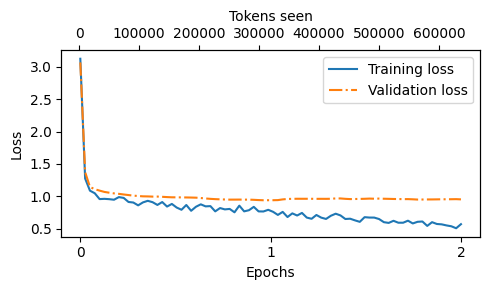

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader_medio, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Perda Inicial (Training loss):", train_loss)
print("Perda Inicial (Validation loss):", val_loss)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
start_time = time.time()

print("\nIniciando Treinamento GPT-2 (Dataset Médio)...")
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader_medio, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
print(f"Treino concluído em {(time.time() - start_time) / 60:.2f} minutos.")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5. Gerando as Respostas Pós-Treino e Salvando o Modelo
Geração das respostas do modelo adaptado para comparativo com o Baseline.

In [ ]:
import json
import torch

model.eval()

print("--- Avaliação Visual (3 exemplos) ---\n")
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Resposta:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

print("\nA gerar respostas FINE-TUNED para todo o conjunto de teste...")

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=25, # Reduzido para 25 aqui apenas para gerar rápido
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Resposta:", "").strip()

    test_data[i]["model_ft_medio_response"] = response_text

# Guardar o JSON com as respostas
with open("instruction-data-with-response.json", "w", encoding="utf-8") as file:
    json.dump(test_data, file, indent=4, ensure_ascii=False)

# Guardar os pesos do modelo treinado
torch.save(model.state_dict(), "gpt2-medium-ft-medio.pth")

print("\nConcluído! Dados guardados em 'instruction-data-with-response.json'")
print("Pesos do modelo guardados em 'gpt2-medium-ft-medio.pth'")

--- Avaliação Visual (3 exemplos) ---

Abaixo está uma instrução que descreve uma tarefa. Escreva uma resposta que conclua a solicitação adequadamente.

### Instrução:
Classifique o texto da notícia abaixo em uma das seguintes categorias: Mundo, Esportes, Negócios ou Ciência/Tecnologia.

### Entrada:
New OSes, applications from PalmSource PalmSource has been busy lately, and has now announced updates to both of its OS lines as well as a new web browser and OTA installer.

Correct response:
>> Ciência/Tecnologia

Model response:
>> Ciência/Tecnologia
-------------------------------------
Abaixo está uma instrução que descreve uma tarefa. Escreva uma resposta que conclua a solicitação adequadamente.

### Instrução:
Classifique o texto da notícia abaixo em uma das seguintes categorias: Mundo, Esportes, Negócios ou Ciência/Tecnologia.

### Entrada:
Israel scales back Gaza offensive as Palestinians mark Ramadan JERUSALEM : Israel scaled back its vast operation in northern Gaza despite the d

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]



Concluído! Dados guardados em 'instruction-data-with-response.json'
Pesos do modelo guardados em 'gpt2-medium-ft-medio.pth'


## 6. Setup do Juiz LLM: Liberação de Memória e Subida do Ollama
Limpando a GPU e utilizando o Ollama local (Llama 3.2) para atuar como Juiz entre o modelo Baseline e o Fine-Tuned.

In [ ]:
!apt-get update -y
!apt-get install -y zstd
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
import time

# Inicia o servidor do Ollama em segundo plano
print("Iniciando o servidor Ollama...")
process = subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Aguarda uns segundos para o servidor inicializar completamente
time.sleep(5)
print("Servidor Ollama rodando no background!")

!ollama pull llama3.2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,361 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 https://cli.github.com/packages stable/main amd64 Packages [355 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,904 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restrict

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [ ]:
import os
import time

# O comando nohup força o processo a rodar no background sem travar o Colab
print("Iniciando o servidor Ollama em segundo plano...")
os.system("nohup ollama serve > ollama_server.log 2>&1 &")

time.sleep(5)

print("Servidor iniciado! Verificando os logs iniciais:")
# Exibe as primeiras linhas do log para confirmar que funcionou
!cat ollama_server.log | head -n 5

Iniciando o servidor Ollama em segundo plano...
Servidor iniciado! Verificando os logs iniciais:
Error: listen tcp 127.0.0.1:11434: bind: address already in use


## 7. Pipeline de Avaliação Final (LLM-as-a-Judge)

## 7.1 Evaluating the finetuned LLM
Nesta secção, utilizamos o LLM-as-a-Judge (Llama 3.2 via Ollama local) para avaliar comparativamente o Modelo BASE (A) e o Modelo FINE-TUNED (B), conforme exigido no laboratório.

In [ ]:
import urllib.request
import json
import os
import time
import subprocess

# 1. Limpeza para evitar OOM (Out of Memory)
if 'model' in locals():
    del model
torch.cuda.empty_cache()

# 2. Iniciar o Ollama (adaptado para o Colab não falhar)
print("A iniciar o servidor Ollama...")
os.system("curl -fsSL https://ollama.com/install.sh | sh")
os.system("pkill ollama")
time.sleep(2)
subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(5)
print("A descarregar Llama 3.2...")
os.system("ollama pull llama3.2")

def query_model(prompt, model="llama3.2", url="http://127.0.0.1:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")

    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

try:
    print("\nTeste de ligação:", query_model("Responda apenas 'OK'."))
except Exception as e:
    print(f"Erro na ligação ao Ollama: {e}")

A iniciar o servidor Ollama...
A descarregar Llama 3.2...

Teste de ligação: OK.


### Gerando as pontuações (Scoring)
Criamos o *prompt* comparativo e avaliamos todas as entradas do conjunto de teste, extraindo as métricas utilizando expressões regulares (RegEx).

In [ ]:
import re
import numpy as np
from tqdm import tqdm

prompt_template = """Você é um juiz imparcial avaliando dois modelos de Inteligência Artificial em uma tarefa de classificação de texto.

Instrução: {instrucao}
Entrada: {entrada}
Gabarito (Resposta Correta): {gabarito}

Resposta Modelo A (Base): {resp_a}
Resposta Modelo B (Fine-tuned): {resp_b}

Avalie os dois modelos dando uma nota inteira de 0 a 5 para:
1. Correção factual
2. Aderência à instrução
3. Clareza/utilidade

Responda ESTRITAMENTE neste formato:
Modelo A - Correção: [nota], Aderência: [nota], Clareza: [nota]
Modelo B - Correção: [nota], Aderência: [nota], Clareza: [nota]
Vencedor: [A, B ou Empate]
Justificativa: [breve justificativa]
"""

resultados_avaliacao = []
erros = 0

print("A avaliar entradas do conjunto de teste...")
for entry in tqdm(test_data, desc="Scoring entries"):
    prompt = prompt_template.format(
        instrucao=entry['instruction'],
        entrada=entry.get('input', ''),
        gabarito=entry['output'],
        resp_a=entry.get('model_base_response', ''),
        resp_b=entry.get('model_ft_medio_response', '')
    )

    try:
        judge_response = query_model(prompt)
        entry['judge_evaluation'] = judge_response
        resultados_avaliacao.append(entry)
    except Exception as e:
        erros += 1

print(f"\nAvaliações concluídas. Falhas de conexão: {erros}")

A avaliar entradas do conjunto de teste...


Scoring entries: 100%|██████████| 200/200 [22:50<00:00,  6.85s/it]


Avaliações concluídas. Falhas de conexão: 0


### Calculando as Médias e Exportando os Resultados
Processamos o texto gerado pelo Juiz para calcular as vitórias e as pontuações médias de cada modelo.

In [ ]:
import re
import numpy as np
import json

vitorias = {'A': 0, 'B': 0, 'Empate': 0}
scores_A = {'Correcao': [], 'Aderencia': [], 'Clareza': []}
scores_B = {'Correcao': [], 'Aderencia': [], 'Clareza': []}

falhas_parse = 0

for entry in resultados_avaliacao:
    eval_text = entry.get('judge_evaluation', '')

    match_vencedor = re.search(r"Vencedor\s*[:\*]*\s*(?:Modelo\s*)?([A-Za-z]+)", eval_text, re.IGNORECASE)

    match_A = re.search(r"Modelo A.*?Corre[çc][ãa]o.*?(\d).*?Ader[êe]ncia.*?(\d).*?Clareza.*?(\d)", eval_text, re.IGNORECASE | re.DOTALL)
    match_B = re.search(r"Modelo B.*?Corre[çc][ãa]o.*?(\d).*?Ader[êe]ncia.*?(\d).*?Clareza.*?(\d)", eval_text, re.IGNORECASE | re.DOTALL)

    try:
        # Verifica o Vencedor
        if match_vencedor:
            v = match_vencedor.group(1).upper()
            if "A" in v: vitorias['A'] += 1
            elif "B" in v: vitorias['B'] += 1
            elif "EMP" in v or "TIE" in v: vitorias['Empate'] += 1
            else: vitorias['Empate'] += 1

        # Verifica as Notas
        if match_A and match_B:
            scores_A['Correcao'].append(int(match_A.group(1)))
            scores_A['Aderencia'].append(int(match_A.group(2)))
            scores_A['Clareza'].append(int(match_A.group(3)))

            scores_B['Correcao'].append(int(match_B.group(1)))
            scores_B['Aderencia'].append(int(match_B.group(2)))
            scores_B['Clareza'].append(int(match_B.group(3)))
        else:
            falhas_parse += 1

    except ValueError:
        falhas_parse += 1

# Impressão final ao estilo do Ch07
total_avaliacoes = len(scores_A['Correcao'])

print(f"Number of scores parsed successfully: {total_avaliacoes} of {len(test_data)}")
if falhas_parse > 0:
    print(f"Failed to parse {falhas_parse} evaluations due to formatting issues.")

if total_avaliacoes > 0:
    print("\n--- WIN RATES ---")
    print(f"Base Model (A) Wins:       {vitorias['A']} ({(vitorias['A']/total_avaliacoes)*100:.1f}%)")
    print(f"Fine-Tuned Model (B) Wins: {vitorias['B']} ({(vitorias['B']/total_avaliacoes)*100:.1f}%)")
    print(f"Ties (Empates):            {vitorias['Empate']} ({(vitorias['Empate']/total_avaliacoes)*100:.1f}%)")

    print("\n--- AVERAGE SCORES (0-5) ---")
    print("Base Model (A):")
    print(f"  Correção:  {np.mean(scores_A['Correcao']):.2f}")
    print(f"  Aderência: {np.mean(scores_A['Aderencia']):.2f}")
    print(f"  Clareza:   {np.mean(scores_A['Clareza']):.2f}")

    print("\nFine-Tuned Model (B):")
    print(f"  Correção:  {np.mean(scores_B['Correcao']):.2f}")
    print(f"  Aderência: {np.mean(scores_B['Aderencia']):.2f}")
    print(f"  Clareza:   {np.mean(scores_B['Clareza']):.2f}")

# Atualiza o JSON com os dados consolidados
with open("dataset_avaliado_final.json", "w", encoding='utf-8') as f:
    json.dump(resultados_avaliacao, f, ensure_ascii=False, indent=4)

Number of scores parsed successfully: 200 of 200

--- WIN RATES ---
Base Model (A) Wins:       6 (3.0%)
Fine-Tuned Model (B) Wins: 192 (96.0%)
Ties (Empates):            2 (1.0%)

--- AVERAGE SCORES (0-5) ---
Base Model (A):
  Correção:  2.79
  Aderência: 1.82
  Clareza:   2.21

Fine-Tuned Model (B):
  Correção:  4.22
  Aderência: 4.68
  Clareza:   4.14


In [ ]:
import re
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc=f"Scoring {json_key}"):
        # Prompt fiel ao original do livro, mas em português
        prompt = (
            f"Dada a entrada `{format_input(entry)}` "
            f"e a saída correta (gabarito) `{entry['output']}`, "
            f"avalie a resposta do modelo `{entry.get(json_key, '')}` "
            f"numa escala de 0 a 100, onde 100 é a nota máxima e 0 é a mínima. "
            f"Responda APENAS com o número inteiro, sem textos adicionais."
        )

        score_text = query_model(prompt, model)

        try:
            # Tenta a conversão direta igual ao livro
            score = int(score_text.strip())
            scores.append(score)
        except ValueError:
            match = re.search(r"(\d+)", score_text)
            if match:
                scores.append(int(match.group(1)))
            else:
                print(f"\nCould not convert score: {score_text}")
                continue

    return scores

print("--- AVALIAÇÃO DE 0 A 100 (Estilo Capítulo 7) ---")


scores_ft = generate_model_scores(test_data, "model_ft_medio_response")

print(f"\nResultados para o Modelo Fine-Tuned:")
print(f"Number of scores: {len(scores_ft)} of {len(test_data)}")
if len(scores_ft) > 0:
    print(f"Average score: {sum(scores_ft)/len(scores_ft):.2f}\n")

--- AVALIAÇÃO DE 0 A 100 (Estilo Capítulo 7) ---


Scoring model_ft_medio_response: 100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


Resultados para o Modelo Fine-Tuned:
Number of scores: 200 of 200
Average score: 76.75

